In [1]:
!git clone https://github.com/pytorch-labs/applied-ai.git
%cd applied-ai/kernels/cuda/inference/hadamard_transform
!pip install ninja
!python setup.py install

!pip install git+https://github.com/Dao-AILab/fast-hadamard-transform.git

Cloning into 'applied-ai'...
remote: Enumerating objects: 1727, done.
remote: Counting objects: 100% (523/523), done.
remote: Compressing objects: 100% (290/290), done.
remote: Total 1727 (delta 309), reused 349 (delta 220), pack-reused 1204 (from 1)
Receiving objects: 100% (1727/1727), 69.11 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (758/758), done.
/content/applied-ai/kernels/cuda/inference/hadamard_transform
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 6.2 MB/s eta 0:00:00
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ***************

In [2]:
import os
import sys
import ctypes
from glob import glob

# Path to PyTorch's shared libs
torch_lib_path = "/usr/local/lib/python3.11/dist-packages/torch/lib"

# Update LD_LIBRARY_PATH
os.environ["LD_LIBRARY_PATH"] = f"{torch_lib_path}:{os.environ.get('LD_LIBRARY_PATH', '')}"

# Preload all shared libraries in the torch/lib directory
for so_file in glob(f"{torch_lib_path}/*.so"):
    try:
        ctypes.CDLL(so_file, mode=ctypes.RTLD_GLOBAL)
    except OSError as e:
        print(f"Could not load {so_file}: {e}")

# Add extension to Python path
sys.path.append('/usr/local/lib/python3.11/dist-packages/faster_hadamard_transform-0.0.0-py3.11-linux-x86_64.egg')

# Import HadaCore
import faster_hadamard_transform
print("faster_hadamard_transform loaded successfully.")


faster_hadamard_transform loaded successfully.


Size         Dense (ms)   FWHT (ms)    Dao (ms)     HadaCore (ms) FWHT Speedup Dao Speedup  HadaCore Speedup
32            0.216        2.816        0.083           0.064            0.08x         2.60x             3.39x
64            0.224        4.554        0.073           0.049            0.05x         3.08x             4.57x
128           0.381        9.338        0.074           0.048            0.04x         5.16x             7.95x
256           0.541       17.521        0.076           0.049            0.03x         7.08x            11.08x
512           1.261       35.098        0.085           0.049            0.04x        14.90x            25.63x
1024          5.348       68.907        0.078           0.050            0.08x        68.80x           107.45x
2048         30.641      137.431        0.105           0.096            0.22x       291.71x           320.55x
4096        143.550      275.516        0.369           0.340            0.52x       388.55x           422.40x
819

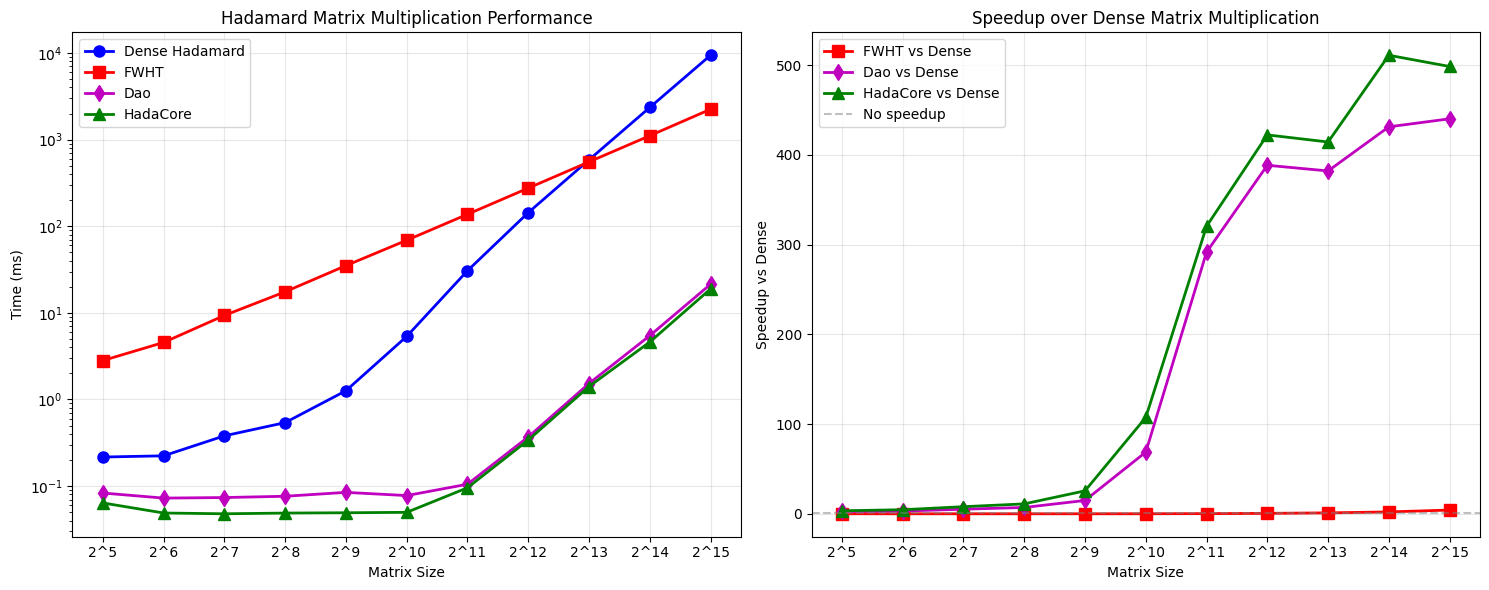

In [3]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import faster_hadamard_transform
import scipy.linalg
from fast_hadamard_transform import hadamard_transform

def fwht_hadamard_multiply(X):

   N, N2 = X.shape
   assert N == N2 and (N & (N - 1)) == 0

   result = X.clone()
   step = 1

   while step < N:
       for i in range(0, N, step * 2):
           if i + step < N:
               a = result[i:i+step, :]
               b = result[i+step:i+step*2, :]
               result[i:i+step, :] = a + b
               result[i+step:i+step*2, :] = a - b
       step *= 2

   return result

def dao_hadamard_multiply(X):

   N, N2 = X.shape
   assert N == N2 and (N & (N - 1)) == 0

   # Transpose, apply hadamard transform, transpose back
   X_T = X.T.contiguous()
   result_T = hadamard_transform(X_T)
   result = result_T.T

   return result

def hadacore_hadamard_multiply(X):

   N, N2 = X.shape
   assert N == N2 and (N & (N - 1)) == 0

   # Transpose, apply hadamard transform, transpose back
   X_T = X.T.contiguous()
   result_T = faster_hadamard_transform.hadamard_transform(X_T, inplace=False)
   result = result_T.T

   return result

def dense_hadamard_multiply(X):

   N = X.shape[0]
   H = torch.tensor(scipy.linalg.hadamard(N), device=X.device, dtype=X.dtype)

   return H @ X

# Benchmark
matrix_sizes = [2 ** k for k in range(5, 16)]
num_trials = 30
results = []

print(f"{'Size':<12} {'Dense (ms)':<12} {'FWHT (ms)':<12} {'Dao (ms)':<12} {'HadaCore (ms)':<12} {'FWHT Speedup':<12} {'Dao Speedup':<12} {'HadaCore Speedup':<12}")

for N in matrix_sizes:
   # Create test matrix
   X = torch.randn(N, N, device="cuda", dtype=torch.float16)

   # Warmup
   for _ in range(3):
       _ = dense_hadamard_multiply(X)
       _ = fwht_hadamard_multiply(X.clone())
       _ = dao_hadamard_multiply(X.clone())
       _ = hadacore_hadamard_multiply(X.clone())

   torch.cuda.synchronize()

   # Benchmark Dense
   start = time.time()
   for _ in range(num_trials):
       result_dense = dense_hadamard_multiply(X)
   torch.cuda.synchronize()
   dense_time = (time.time() - start) / num_trials

   # Benchmark FWHT
   start = time.time()
   for _ in range(num_trials):
       result_fwht = fwht_hadamard_multiply(X.clone())
   torch.cuda.synchronize()
   fwht_time = (time.time() - start) / num_trials

   # Benchmark Dao
   start = time.time()
   for _ in range(num_trials):
       result_dao = dao_hadamard_multiply(X.clone())
   torch.cuda.synchronize()
   dao_time = (time.time() - start) / num_trials

   # Benchmark HadaCore
   start = time.time()
   for _ in range(num_trials):
       result_hada = hadacore_hadamard_multiply(X.clone())
   torch.cuda.synchronize()
   hada_time = (time.time() - start) / num_trials

   # Calculate speedups
   fwht_speedup = dense_time / fwht_time
   dao_speedup = dense_time / dao_time
   hada_speedup = dense_time / hada_time

   # Store results
   results.append({
       'size': N,
       'dense_time': dense_time * 1000,
       'fwht_time': fwht_time * 1000,
       'dao_time': dao_time * 1000,
       'hada_time': hada_time * 1000,
       'fwht_speedup': fwht_speedup,
       'dao_speedup': dao_speedup,
       'hada_speedup': hada_speedup
   })

   dao_time_str = f"{dao_time*1000:.3f}"
   dao_speedup_str = f"{dao_speedup:.2f}x"
   hada_time_str = f"{hada_time*1000:.3f}"
   hada_speedup_str = f"{hada_speedup:.2f}x"

   print(f"{N:<8} {dense_time*1000:>10.3f}   {fwht_time*1000:>10.3f}   {dao_time_str:>10}   {hada_time_str:>13}   {fwht_speedup:>13.2f}x   {dao_speedup_str:>11}   {hada_speedup_str:>15}")

# Plot results
sizes = [r['size'] for r in results]
dense_times = [r['dense_time'] for r in results]
fwht_times = [r['fwht_time'] for r in results]
dao_times = [r['dao_time'] for r in results]
hada_times = [r['hada_time'] for r in results]
hada_sizes = [r['size'] for r in results]
powers = [int(np.log2(size)) for size in sizes]
hada_powers = [int(np.log2(size)) for size in hada_sizes]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Performance plot
ax1.plot(powers, dense_times, 'b-o', label='Dense Hadamard', linewidth=2, markersize=8)
ax1.plot(powers, fwht_times, 'r-s', label='Naive FWHT', linewidth=2, markersize=8)
ax1.plot(hada_powers, dao_times, 'm-d', label='Dao', linewidth=2, markersize=8)
ax1.plot(hada_powers, hada_times, 'g-^', label='HadaCore', linewidth=2, markersize=8)
ax1.set_xticks(powers)
ax1.set_xticklabels([f'2^{p}' for p in powers])
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Hadamard Matrix Multiplication Performance')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Speedup plot
fwht_speedups = [r['fwht_speedup'] for r in results]
dao_speedups = [r['dao_speedup'] for r in results]
hada_speedups = [r['hada_speedup'] for r in results]
ax2.plot(powers, fwht_speedups, 'r-s', label='Naive FWHT vs Dense', linewidth=2, markersize=8)
valid_hada_powers = [int(np.log2(r['size'])) for r in results if r['hada_speedup'] > 0]
ax2.plot(valid_hada_powers, dao_speedups, 'm-d', label='Dao vs Dense', linewidth=2, markersize=8)
ax2.plot(valid_hada_powers, hada_speedups, 'g-^', label='HadaCore vs Dense', linewidth=2, markersize=8)
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='No speedup')
ax2.set_xticks(powers)
ax2.set_xticklabels([f'2^{p}' for p in powers])
ax2.set_xlabel('Matrix Size')
ax2.set_ylabel('Speedup vs Dense')
ax2.set_title('Speedup over Dense Matrix Multiplication')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()
